# Машинное обучение, DS-поток, осень 2024
## Задание ML.13


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **185 баллов**

Всего &mdash; **185 баллов**  

In [ ]:
# Bot check

# HW_ID: ds_ml13
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

#### 7. Применение модели в реальной жизни (10 баллов)
Примените лучшую модель к своим фото карт, главное, не берите фото из тренировочных и тестовых данных. Оцените качество визуально.

In [62]:
class PlayingCardsDataset(Dataset):
    def __init__(self, images_path, input_size=(160, 240)):
        """
        Класс-датасет для задачи детекции игральных карт.
        """

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((300, 300)),
            # Решайте сами, когда и зачем вам нужан нормализация
            transforms.Normalize(mean=MEAN, std=STD)])

        images = self._read_images(images_path)
        self.images = images


    def _read_images(self, images_path):
        """
        Загружаем все изображения, а также соотвествующие им боксы и лейблы.
        """

        images = []

        for file in os.listdir(images_path):
            image =  self.transform(Image.open(os.path.join(images_path, file)))
            images.append(image)

        return images

    def __len__(self,):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

In [63]:
data_path = 'myimages'
my_dataset = PlayingCardsDataset(data_path)

In [64]:
def plot_predictions(dataset, model, classes, min_score=0.8, max_overlap=0.2, top_k=10):
    '''Строит предсказания model для нескольких картинок из dataset
    * classes -- метки классов'''

    fig, axes = plt.subplots(3, 3, figsize=(15, 20))
    cnt = 0
    for i in range(3):
        for j in range(3):
            image = dataset[cnt]
            axes[i, j].imshow(image.permute(1, 2, 0))
            axes[i, j].axis("off")
            plt.tight_layout()
            img = dataset[cnt].to(device)
            predicted_pos, predicted_scores = model(img.unsqueeze(0))
            det_boxes, det_labels, det_scores = model.detect_objects(predicted_pos,
                                                                     predicted_scores,
                                                                     min_score=min_score,
                                                                     max_overlap=max_overlap,
                                                                     top_k=top_k)
            pred_boxes = det_boxes[0].detach().cpu()
            pred_labels = det_labels[0].detach().cpu()
            plot_boxes(pred_boxes * 300,
                       pred_labels,
                       classes,
                       axes[i, j],
                       scores=det_scores[0].detach().cpu())
            cnt += 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0734293..2.4032178].
/tmp/ipykernel_41519/2307094198.py:179: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/IndexingUtils.h:27.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/tmp/ipykernel_41519/2307094198.py:181: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/IndexingUtils.h:27.)
  image_scores.append(class_scores[1 - suppress])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.897939..2.4214988].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..

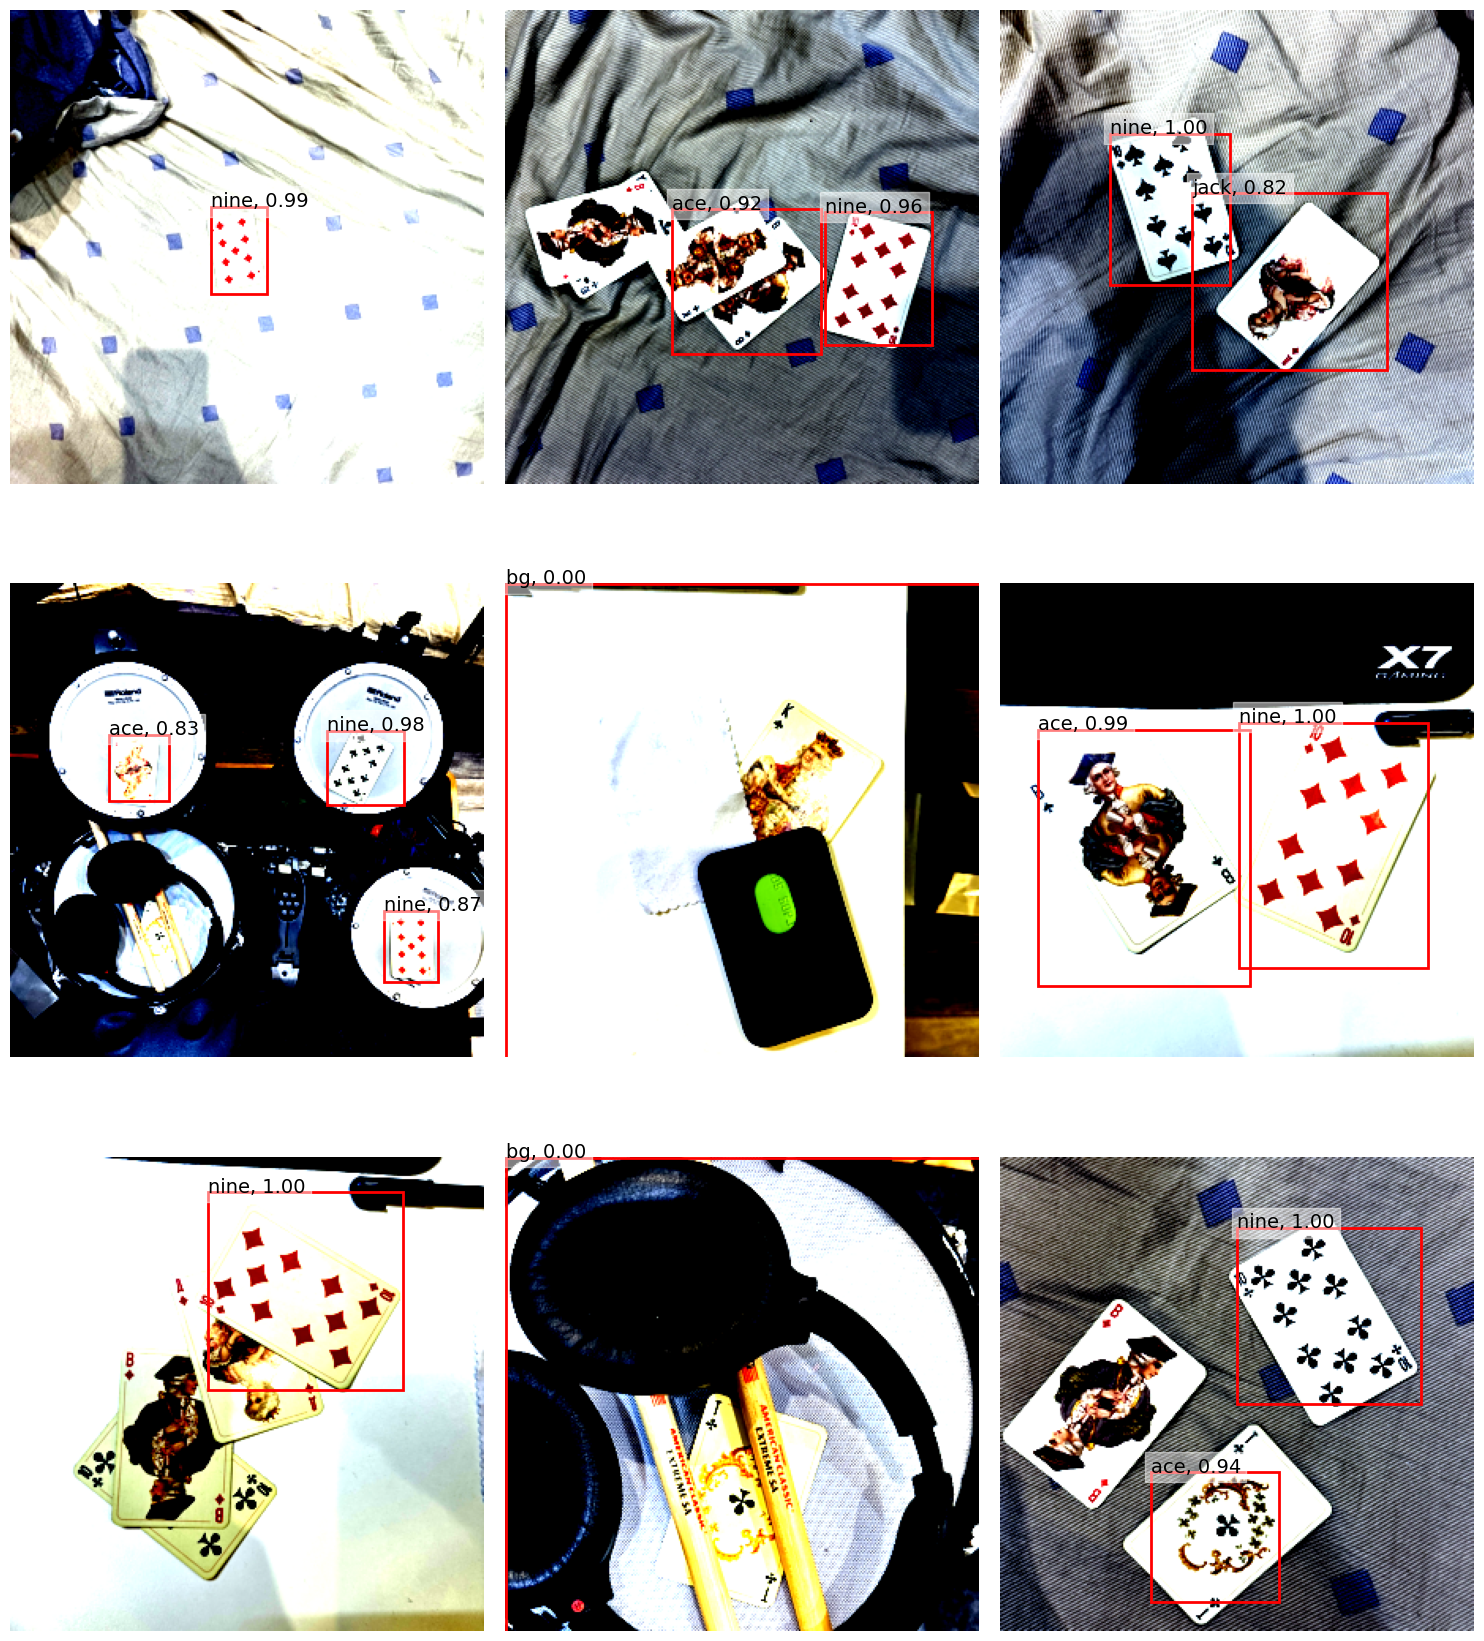

In [65]:
plot_predictions(my_dataset, model, classes)

Вывод:

Модель стала работать существенно хуже, снова путает 9 и 10, королев с валетами, короля на 5 фото вообще не раглядела. О возможных причинах скажу в финальном выводе.

#### 8. Вывод по всей задаче (5 баллов)

1. Модель без увеличенных FM сложно отделяет похожие карты друг от друга и мелкие карты от фона
2. Модель с увеличенными FM справляется с такими сложностями намного лучше
3. На моих собственных фото модель работает так себе, вероятно из-за другого освещения, настроек камеры, нужна другая нормализация (которую надо вычислять из параметров камеры и алгоритмов айфона, без нормализации работает хуже, я проверял). Кроме того, у меня карты с желтоватым оттенком и русскими буквами вместо английских. Все это говорит, о том что модель в данном виде неустойчива к внешним условиям, значит надо либо сильно расширять датасет, либо применять кучу аугментаций.